<class 'numpy.ndarray'>


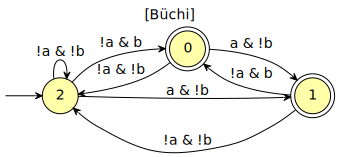

In [41]:
import spot
import numpy as np

class Specification:

    def __init__(self, formula=None, hoa=None, reward=1):

        # Spot Formula
        self.reward = reward

        if formula:
            self.formula = spot.from_ltlf(formula)
            # Translate Automaton
            self.automaton = self.formula.translate('small', 'buchi', 'sbacc')
            self.automaton = spot.to_finite(self.automaton)     
        elif hoa:
            for a in spot.automata(hoa):
                self.automaton = a
        else:
            raise("Required LTL formula or HOA.")

        # Building automaton
        self.init = self.automaton.get_init_state_number()
        self.state = self.init
        self.num_states = self.automaton.num_states()

        self.bdict = self.automaton.get_dict()

        self.variables = self.get_variables()
        self.transitions = {}
        self.acceptances = {}

        for state in range(0, self.num_states):

            self.transitions[state] = []

            self.acceptances[state] = True if self.automaton.state_acc_sets(state) else False

            for transition in self.automaton.out(state):

                self.transitions[state].append({
                    "dst": transition.dst,
                    "cond": self.map_bdd(transition.cond),
                    "cond_str": spot.bdd_format_formula(self.bdict, transition.cond)
                })

    def reset(self):
        self.state = self.init
        encoded_state = self.encode_state(self.state)
        return encoded_state

    def __len__(self):
        return self.num_states

    def __str__(self):
        str_ = ""
        for s in range(0, self.num_states):
            str_ += "\n State {}:".format(s)
            str_ += "\n  acc sets = {}".format(self.acceptances[s])
            for t in self.transitions[s]:
                str_ += "\n  edge({} -> {})".format(s, t["dst"])
                str_ += "\n    label = {}".format(t["cond_str"])
                
        return str_

    def encode_state(self, state):
        encoded_state = np.zeros((self.__len__()))
        encoded_state[state] = 1
        return encoded_state

    
                
    def map_bdd(self, cond):
        cond = spot.bdd_format_formula(self.bdict, cond)
    
        cond = cond.replace("!", " not ")
        cond = cond.replace("|", " or ")
        cond = cond.replace("&", " and ")        

        variables = ", ".join(self.variables)
        cond = eval("lambda {}: {}".format(variables, cond))
        
        return cond

    def get_variables(self):
        variables = [str(a) for a in spec.automaton.ap()]
        return set(variables)

    def step(self, *arglist, **keywords):
        
        for transition in self.transitions[self.state]:
            if transition["cond"](**keywords):
                self.state = transition["dst"]  

        reward = 0
        if self.acceptances[self.state]: reward=self.reward

        encoded_state = self.encode_state(self.state)
            
        return encoded_state, reward, False

spec = Specification("G(a -> !X[!]a) & G(b -> !X[!]b) & G!(a & b) & G((!a&!b) -> F(a|b))")
state1 = spec.reset()
print(type(state1))
# state2, _, _  = spec.step(a=True, b=False, alive=True)
# print(state2) 
spec.automaton

In [44]:
print(hoa)

HOA: v1
States: 3
Start: 2
AP: 2 "a" "b"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc deterministic
--BODY--
State: 0 {0}
[0&!1] 1
[(!0&!1)|1] 2
State: 1 {0}
[!0&1] 0
[(!0&!1)|0] 2
State: 2
[!0&1] 0
[0&!1] 1
[!0&!1] 2
--END--


In [38]:
str(spec.automaton.ap()[0])

'a'

In [25]:
(spot.bdd_to_formula(spec.automaton.ap_vars()))

a & b


In [33]:
spot.bdd_dict(spec.automaton.ap_vars())

TypeError: __init__() takes 1 positional argument but 2 were given

In [1]:
import subprocess
import spot
import numpy as np
from spot.jupyter import display_inline

from IPython.display import display

spot.setup()

Concepts (FLAGS and Automaton) :
https://spot.lre.epita.fr/concepts.html

spot.formula("Fb & (Fb -> FXa)")

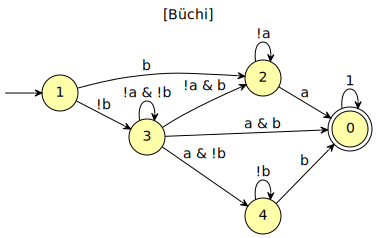

In [2]:
f = spot.formula("F(b) & ( (F b) -> (F(X a)) )")
display(f)
a = spot.translate(f, 'det', 'sbacc')
a

spot.formula("Fb & G!(a & b) & (Fb U Fa)")

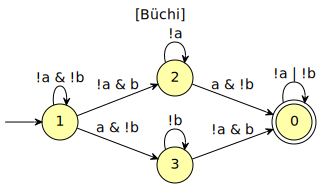

In [3]:
f = spot.formula("G!(a&b) & (F b) & ( (F b) U (F a) )")
display(f)
a = spot.translate(f)
a

spot.formula("Fb & G!(a & b) & G(b -> Fa)")

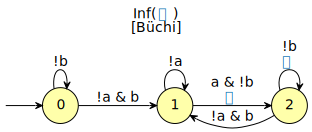

In [4]:
f = spot.formula("G!(a&b) & (F b) & G( (b) -> (F a) )")
display(f)
a = spot.translate(f, "Buchi")
a

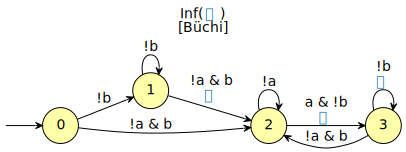

In [5]:
rabinizer_dir = '/home/crarojasca/Storage/Monash/HRL_LTL_Goals/almanac/src/rabinizer4'
def get_aut(ltl):
    aut = subprocess.check_output(
        "bin/ltl2ldba \"{}\"".format(ltl), 
        cwd=rabinizer_dir, shell=True)
    a = spot.automaton(aut.decode('utf-8'))
    return a

ltl = "G!(a&b) & (F b) & G( (b) -> (F a) )"
a = get_aut(ltl)
a

 B => A

spot.formula("Fb & G!(a & b) & G(b -> Fa) & G(a -> X!alive)")

spot.formula("alive & F(alive & b) & G(!alive | !(a & b)) & G(!alive | (b -> F(a & alive))) & G(!alive | (a -> X!alive)) & (alive U G!alive)")

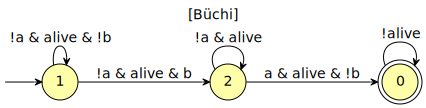

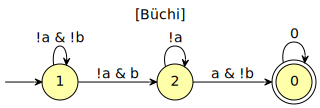

In [6]:
f = spot.formula("G!(a&b) & (F b) & G( (b) -> (F a) ) & G( a -> X !alive)")
display(f)
f = spot.from_ltlf("G!(a&b) & (F b) & G( (b) -> (F a) ) & G( a -> X !alive)")
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
display(aut)
aut = spot.to_finite(aut)
aut

## Automaton FourRooms

spot.formula("G!((a & b & c) | (a & b) | (a & c) | (b & c)) & Fa & G(a -> Fb) & G(b -> (Fc & !Fa)) & G(c -> X!alive)")

spot.formula("alive & G(!alive | !((a & b & c) | (a & b) | (a & c) | (b & c))) & F(a & alive) & G(!alive | (a -> F(alive & b))) & G(!alive | (b -> (F(alive & c) & !F(a & alive)))) & G(!alive | (c -> X!alive)) & (alive U G!alive)")

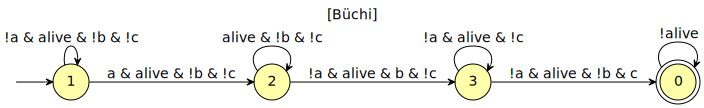

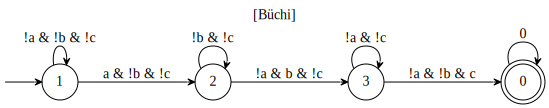

In [7]:
formula = "G!(a&b&c | a&b | a&c | b&c)  & (F a) & G( a -> (F b)  ) & G( b -> (F c & !F a) ) & G( c -> X !alive)"
f = spot.formula(formula)
display(f)
f = spot.from_ltlf(formula)
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
display(aut)
aut = spot.to_finite(aut)
aut.show("h")

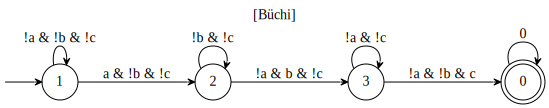

In [8]:
aut.show("h")

## Automaton Structure

In [9]:
bdict = aut.get_dict()
init = aut.get_init_state_number()
ui = aut.is_univ_dest(init)
print("Initial states: {}{}{}".format("{ " if ui else "",
                                      " ".join(map(str, aut.univ_dests(init))),
                                      " }" if ui else ""))
for s in range(0, aut.num_states()):
    print("State {}:".format(s))
    for t in aut.out(s):
        ud = aut.is_univ_dest(t)
        print("  edge({} -> {}{}{})".format(t.src,
                                            "{ " if ud else "",
                                            " ".join(map(str, aut.univ_dests(t))),
                                            " }" if ud else ""))
        print("    label =", spot.bdd_format_formula(bdict, t.cond))
        print("    acc sets =", t.acc)

Initial states: 1
State 0:
  edge(0 -> 0)
    label = 0
    acc sets = {0}
State 1:
  edge(1 -> 1)
    label = !a & !b & !c
    acc sets = {}
  edge(1 -> 2)
    label = a & !b & !c
    acc sets = {}
State 2:
  edge(2 -> 2)
    label = !b & !c
    acc sets = {}
  edge(2 -> 3)
    label = !a & b & !c
    acc sets = {}
State 3:
  edge(3 -> 0)
    label = !a & !b & c
    acc sets = {}
  edge(3 -> 3)
    label = !a & !c
    acc sets = {}


## Sapientino

In [10]:
TOKENS = [ ['r1', 'red', 0, 0],  ['r2', 'red', 1, 1], ['r3', 'red', 6, 3],   
    ['g1', 'green', 4, 0], ['g2', 'green', 5, 2], ['g3', 'green', 5, 4],
    ['b1', 'blue', 1, 3], ['b2', 'blue', 2, 4],  ['b3', 'blue', 6, 0], 
    ['p1', 'pink', 2, 1], ['p2', 'pink', 2, 3], ['p3', 'pink', 4, 2], 
    ['n1', 'brown', 3, 0], ['n2', 'brown', 3, 4], ['n3', 'brown', 6, 1],
    ['y1', 'gray', 0, 2], ['y2', 'gray', 3, 1], ['y3', 'gray', 4, 3],
    ['u1', 'purple', 0, 4], ['u2', 'purple', 1, 0], ['u3', 'purple', 5, 1]
]

spot.formula("G!((a & b & c) | (a & b) | (b & c) | (a & c)) & Fa & Fb & Fc")

spot.formula("alive & G(!alive | !((a & b & c) | (a & b) | (b & c) | (a & c))) & F(a & alive) & F(alive & b) & F(alive & c) & (alive U G!alive)")

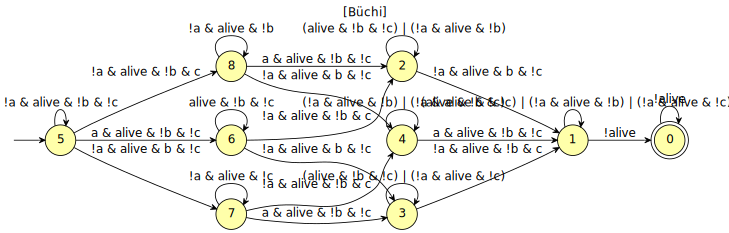

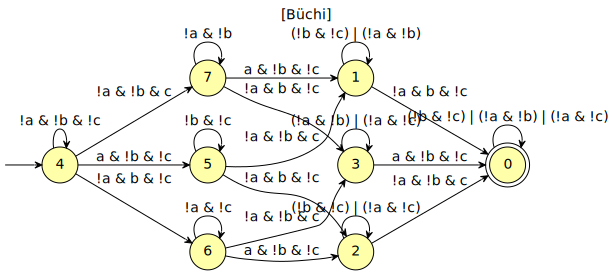

In [11]:
formula = "G!(a&b&c | a&b | b&c | c&a) & ((F a) & (F b) & (F c))"
f = spot.formula(formula)
display(f)
f = spot.from_ltlf(formula)
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
display(aut)
aut = spot.to_finite(aut)
aut

## Car Pole

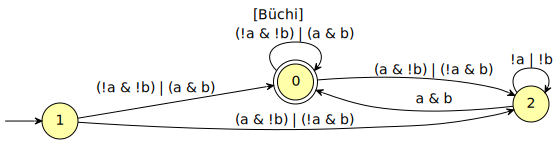

In [12]:
formula = "G (a -> Fb) & G (b -> Fa)"
f = spot.from_ltlf(formula)
aut = f.translate('small', 'buchi', 'sbacc')
aut = spot.to_finite(aut)
aut

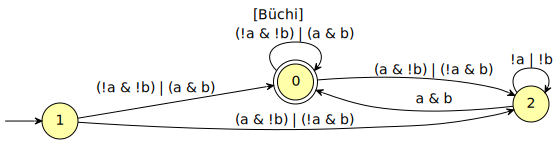

In [13]:
aut.show()

In [14]:
True & True

True

In [15]:
a = False
b = False
c = False

eval("!a & !b & !c".replace("!", "not ").replace("&", "and")) 

True

set()
<class 'numpy.ndarray'>


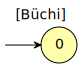

In [2]:
class Specification:

    def __init__(self, formula, reward=1):

        # Spot Formula
        self.reward = reward
        self.formula = spot.from_ltlf(formula)

        # Translate Automaton
        self.automaton = self.formula.translate('small', 'buchi', 'sbacc')
        self.automaton = spot.to_finite(self.automaton)

        # Building automaton
        self.init = self.automaton.get_init_state_number()
        self.state = self.init
        self.num_states = self.automaton.num_states()

        self.bdict = self.automaton.get_dict()

        self.variables = self.get_variables()
        print(self.variables)
        self.transitions = {}
        self.acceptances = {}

        for state in range(0, self.num_states):

            self.transitions[state] = []

            self.acceptances[state] = True if self.automaton.state_acc_sets(state) else False

            for transition in self.automaton.out(state):

                self.transitions[state].append({
                    "dst": transition.dst,
                    "cond": self.map_bdd(transition.cond),
                    "cond_str": spot.bdd_format_formula(self.bdict, transition.cond)
                })

    def reset(self):
        self.state = self.init
        encoded_state = self.encode_state(self.state)
        return encoded_state

    def __len__(self):
        return self.num_states

    def __str__(self):
        str_ = ""
        for s in range(0, self.num_states):
            str_ += "\n State {}:".format(s)
            str_ += "\n  acc sets = {}".format(self.acceptances[s])
            for t in self.transitions[s]:
                str_ += "\n  edge({} -> {})".format(s, t["dst"])
                str_ += "\n    label = {}".format(t["cond_str"])
                
        return str_

    def encode_state(self, state):
        encoded_state = np.zeros((self.__len__()))
        encoded_state[state] = 1
        return encoded_state

    
                
    def map_bdd(self, cond):
        cond = spot.bdd_format_formula(self.bdict, cond)
    
        cond = cond.replace("!", " not ")
        cond = cond.replace("|", " or ")
        cond = cond.replace("&", " and ")        

        variables = ", ".join(self.variables)
        cond = eval("lambda {}: {}".format(variables, cond))
        
        return cond

    def get_variables(self):
        def get_variable(f, variables):
            if f._is(spot.op_ap):
                variables.append(str(f))

        variables = []
        self.formula.traverse(get_variable, variables)
        return set(variables)

    def step(self, *arglist, **keywords):
        
        for transition in self.transitions[self.state]:
            if transition["cond"](**keywords):
                self.state = transition["dst"]  

        reward = 0
        if self.acceptances[self.state]: reward=self.reward

        encoded_state = self.encode_state(self.state)
            
        return encoded_state, reward, False

spec = Specification(formula="(a | b) & G ( (a -> (F (b | !alive)))  & (b -> (F (a | !alive))) ) & G !(a & b)")
state1 = spec.reset()
print(type(state1))
# state2, _, _  = spec.step(a=True, b=False, alive=True)
# print(state2) 
spec.automaton

{'alive', 'a', 'b'}


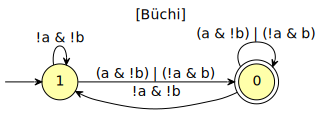

In [17]:
spec = Specification(formula="G((!a&!b) -> F(a|b)) & G!(a & b)")
state1 = spec.reset()
spec.automaton

{'alive', 'a', 'b'}


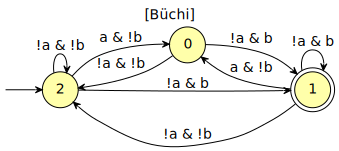

In [18]:
spec = Specification(formula="G((!a&!b) -> F(a|b)) & G(a -> !Xa) & G!(a & b)")
state1 = spec.reset()
spec.automaton

{'alive', 'a', 'b'}


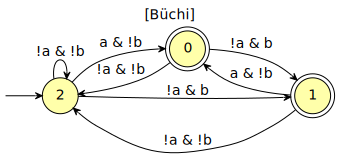

In [31]:
spec = Specification(formula="G((!a&!b) -> F(a|b)) & G(a -> X(!a|!alive)) & G(b -> X(!b|!alive)) & G!(a & b)")
state1 = spec.reset()
spec.automaton

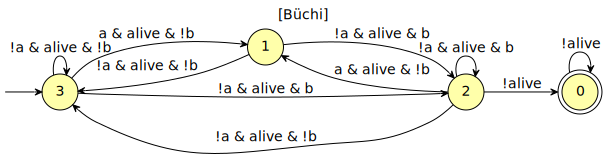

In [20]:
formula = spot.from_ltlf("G((!a&!b) -> F(a|b)) & G(a -> !Xa) & G!(a & b)")

# Translate Automaton
aut = formula.translate()
aut

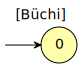

In [21]:
f = "G((!a&!b) -> F(a|b)) & G(a -> !Xa) & G(b -> !Xb) & G!(a & b)"
formula = spot.from_ltlf(f)
# Translate Automaton
aut = formula.translate()
aut = spot.to_finite(aut)
aut

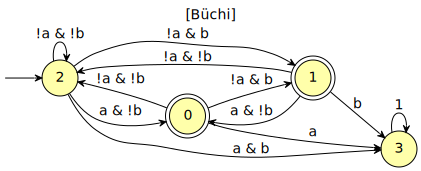

In [22]:
f = "G(a -> !X[!]a) & G(b -> !X[!]b) & G!(a & b) & G((!a&!b) -> F(a|b))"
formula = spot.from_ltlf(f)
# Translate Automaton
aut = formula.translate("complete")
autf = spot.to_finite(aut)
autf

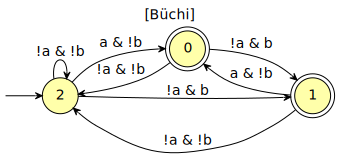

In [23]:
f = "G(a -> !X[!]a) & G(b -> !X[!]b) & G!(a & b) & G((!a&!b) -> F(a|b))"
formula = spot.from_ltlf(f)
# Translate Automaton
aut = formula.translate()
autf = spot.to_finite(aut)
autf

{'a', 'alive', 'b'}


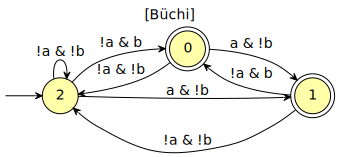

In [3]:
spec = Specification("G(a -> !X[!]a) & G(b -> !X[!]b) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

In [5]:
print(spec.automaton.to_str("hoa"))

HOA: v1
States: 3
Start: 2
AP: 2 "a" "b"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc deterministic
--BODY--
State: 0 {0}
[0&!1] 1
[!0&!1] 2
State: 1 {0}
[!0&1] 0
[!0&!1] 2
State: 2
[!0&1] 0
[0&!1] 1
[!0&!1] 2
--END--


In [6]:
'HOA: v1\nStates: 3\nStart: 2\nAP: 2 "a" "b"\nacc-name: Buchi\nAcceptance: 1 Inf(0)\nproperties: trans-labels explicit-labels state-acc deterministic\n--BODY--\nState: 0 {0}\n[0&!1] 1\n[!0&!1] 2\nState: 1 {0}\n[!0&1] 0\n[!0&!1] 2\nState: 2\n[!0&1] 0\n[0&!1] 1\n[!0&!1] 2\n--END--'

'HOA: v1\nStates: 3\nStart: 2\nAP: 2 "a" "b"\nacc-name: Buchi\nAcceptance: 1 Inf(0)\nproperties: trans-labels explicit-labels state-acc deterministic\n--BODY--\nState: 0 {0}\n[0&!1] 1\n[!0&!1] 2\nState: 1 {0}\n[!0&1] 0\n[!0&!1] 2\nState: 2\n[!0&1] 0\n[0&!1] 1\n[!0&!1] 2\n--END--'

In [37]:
spec.transitions[0][0]["cond"](**{'a': False, 'b': True, 'alive': True})

True

In [30]:
spec.state = 0
spec.step(a=False, b=True, alive=True)

{'a': False, 'b': True, 'alive': True} False !b
{'a': False, 'b': True, 'alive': True} True !a & b


(array([0., 0., 0., 0., 1.]), 1, False)

In [2]:
import spot
import numpy as np

class Specification:

    def __init__(self, formula, reward=1):

        # Spot Formula
        self.reward = reward
        self.formula = spot.from_ltlf(formula)

        # Translate Automaton
        self.automaton = self.formula.translate('small', 'buchi', 'sbacc')
        self.automaton = spot.to_finite(self.automaton)

        # Building automaton
        self.init = self.automaton.get_init_state_number()
        self.state = self.init
        self.num_states = self.automaton.num_states()

        self.bdict = self.automaton.get_dict()

        self.variables = self.get_variables()
        self.transitions = {}
        self.acceptances = {}

        for state in range(0, self.num_states):

            self.transitions[state] = []

            self.acceptances[state] = True if self.automaton.state_acc_sets(state) else False

            for transition in self.automaton.out(state):

                self.transitions[state].append({
                    "dst": transition.dst,
                    "cond": self.map_bdd(transition.cond),
                    "cond_str": spot.bdd_format_formula(self.bdict, transition.cond)
                })

        print(self.transitions)

    def reset(self):
        self.state = self.init
        encoded_state = self.encode_state(self.state)
        return encoded_state

    def __len__(self):
        return self.num_states

    def __str__(self):
        str_ = ""
        for s in range(0, self.num_states):
            str_ += "\n State {}:".format(s)
            str_ += "\n  acc sets = {}".format(self.acceptances[s])
            for t in self.transitions[s]:
                str_ += "\n  edge({} -> {})".format(s, t["dst"])
                str_ += "\n    label = {}".format(t["cond_str"])
                
        return str_

    def encode_state(self, state):
        encoded_state = np.zeros((self.__len__()))
        encoded_state[state] = 1
        return encoded_state

    
                
    def map_bdd(self, cond):
        cond = spot.bdd_format_formula(self.bdict, cond)
    
        cond = cond.replace("!", " not ")
        cond = cond.replace("|", " or ")
        cond = cond.replace("&", " and ")        

        variables = ", ".join(self.variables)
        cond = eval("lambda {}: {}".format(variables, cond))
        
        return cond

    def get_variables(self):
        def get_variable(f, variables):
            if f._is(spot.op_ap):
                variables.append(str(f))

        variables = []
        self.formula.traverse(get_variable, variables)
        return set(variables)

    def step(self, *arglist, **keywords):
        
        for transition in self.transitions[self.state]:
            print(keywords, transition["cond"](**keywords), transition["cond_str"])
            if transition["cond"](**keywords):
                self.state = transition["dst"]  

        reward = 0
        if self.acceptances[self.state]: reward=self.reward

        encoded_state = self.encode_state(self.state)
            
        return encoded_state, reward, False


{0: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10c9550>, 'cond_str': '!a & !b'}], 1: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10efca0>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10efaf0>, 'cond_str': '!a & !b'}]}


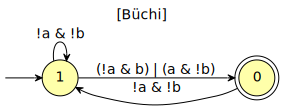

In [28]:
spec = Specification("G(a -> X(!a&!b)) & G(b -> X(!a&!b)) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

{0: [{'dst': 3, 'cond': <function <lambda> at 0x7f55087a23a0>, 'cond_str': '!b'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10efb80>, 'cond_str': '!a & b'}], 1: [{'dst': 3, 'cond': <function <lambda> at 0x7f5508768b80>, 'cond_str': '!a'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a34c0>, 'cond_str': 'a & !b'}], 2: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3550>, 'cond_str': 'a & !b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3430>, 'cond_str': '!a & b'}, {'dst': 3, 'cond': <function <lambda> at 0x7f54f10a3b80>, 'cond_str': '!a & !b'}], 3: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10a30d0>, 'cond_str': '!a & !b'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a31f0>, 'cond_str': '(!a & b) | (a & !b)'}], 4: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10a33a0>, 'cond_str': '!a & !b'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3c10>, 'cond_str': '(!a & b) | (a & !b)'}]}


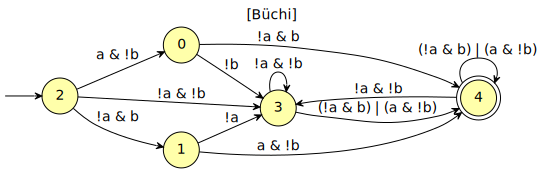

In [29]:
spec = Specification("!G(a & Xa & XX(0)) & !G(b & Xb & XX(0)) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

{0: []}


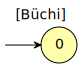

In [26]:
spec = Specification(" G( XX(0) -> !(a & Xa | b & Xb)) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

{0: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3790>, 'cond_str': 'a | b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3670>, 'cond_str': '!a & !b'}], 1: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a34c0>, 'cond_str': 'a | b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3a60>, 'cond_str': '!a & !b'}]}


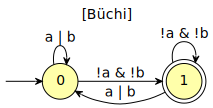

In [27]:
spec = Specification(" G( XX(0) -> !(a & Xa | b & Xb))")
spec.automaton

{0: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10c9ee0>, 'cond_str': 'a'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10c9820>, 'cond_str': '!a'}], 1: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10c9430>, 'cond_str': '!a'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10c9550>, 'cond_str': 'a'}], 2: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10c9700>, 'cond_str': 'a'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3820>, 'cond_str': '!a'}], 3: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10a3670>, 'cond_str': '!a & !b'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a31f0>, 'cond_str': 'a & !b'}], 4: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3940>, 'cond_str': 'a & !b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3790>, 'cond_str': '!a & !b'}]}


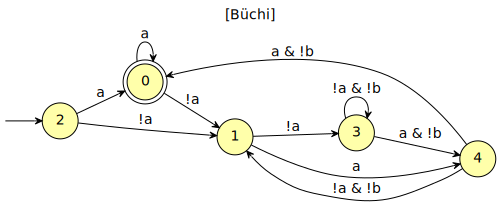

In [18]:
spec = Specification(" G((XXb) -> a) ")
spec.automaton

{0: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10c9790>, 'cond_str': 'a'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10c9e50>, 'cond_str': '!a'}], 1: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10a3430>, 'cond_str': 'a & !b'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a30d0>, 'cond_str': '!a & !b'}], 2: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10a39d0>, 'cond_str': 'a & !b'}, {'dst': 2, 'cond': <function <lambda> at 0x7f54f10a3550>, 'cond_str': '!a & !b'}], 3: [{'dst': 3, 'cond': <function <lambda> at 0x7f54f10a35e0>, 'cond_str': 'a'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a34c0>, 'cond_str': '!a'}], 4: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3310>, 'cond_str': 'a'}, {'dst': 2, 'cond': <function <lambda> at 0x7f54f10a3280>, 'cond_str': '!a'}]}


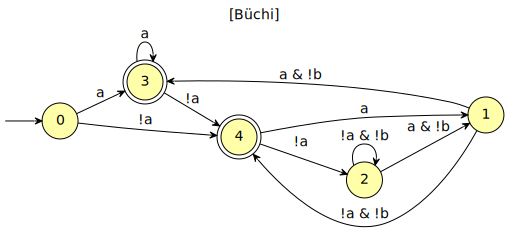

In [19]:
spec = Specification(" G((XXb) -> a) ")
spec.automaton

{0: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10c9f70>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10c9550>, 'cond_str': '!a & !b'}], 1: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10c9ee0>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10c9820>, 'cond_str': '!a & !b'}]}


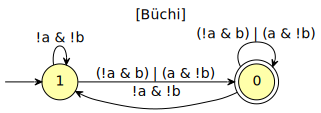

In [8]:
spec = Specification(" G( XX(0) -> !(a & Xa | b & Xb)) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

{0: [{'dst': 3, 'cond': <function <lambda> at 0x7f550c7c6280>, 'cond_str': '!a & !b'}], 1: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10c9790>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 3, 'cond': <function <lambda> at 0x7f54f10c9ee0>, 'cond_str': '!a & !b'}], 2: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10c9550>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 3, 'cond': <function <lambda> at 0x7f54f10c99d0>, 'cond_str': '!a & !b'}], 3: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3430>, 'cond_str': '(!a & b) | (a & !b)'}, {'dst': 3, 'cond': <function <lambda> at 0x7f54f10a34c0>, 'cond_str': '!a & !b'}]}


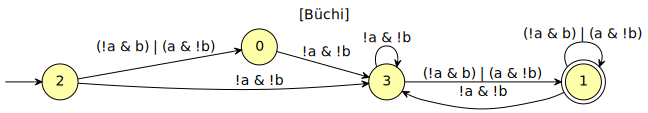

In [10]:
spec = Specification("G!(a & b) & G((!a&!b) -> F((a|b))) & ((a|b) -> X[!](!a&!b))")
spec.automaton

{0: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3040>, 'cond_str': '1'}], 1: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a31f0>, 'cond_str': '!a & !b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3280>, 'cond_str': 'a | b'}]}


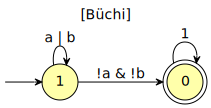

In [11]:
spec = Specification("F((a|b) -> X(!a&!b))")
spec.automaton

{0: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10c9ee0>, 'cond_str': '!a'}, {'dst': 5, 'cond': <function <lambda> at 0x7f54f10a35e0>, 'cond_str': 'a & !b'}], 1: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3040>, 'cond_str': '!a'}, {'dst': 5, 'cond': <function <lambda> at 0x7f54f10a3310>, 'cond_str': 'a & !b'}], 2: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3d30>, 'cond_str': '!a | !b'}], 3: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a38b0>, 'cond_str': '!a & !b'}, {'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3700>, 'cond_str': '!a & b'}, {'dst': 2, 'cond': <function <lambda> at 0x7f54f10a3820>, 'cond_str': 'a & !b'}], 4: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3160>, 'cond_str': '!a & !b'}, {'dst': 5, 'cond': <function <lambda> at 0x7f54f10a3670>, 'cond_str': '(!a & b) | (a & !b)'}], 5: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10a31f0>, 'cond_str': '!a & !b'}, {'dst': 5, 'cond': <function <lambda> at 0x7f54f10a3790>, 'cond_str': 

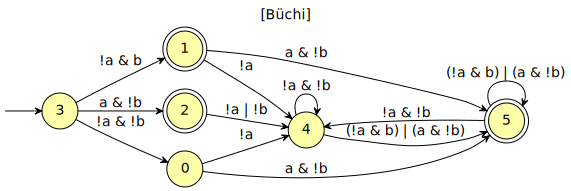

In [22]:
spec = Specification("(X[!]X(0) -> (!a&Xa)) & G!(a & b) & G((!a&!b) -> F(a|b))")
spec.automaton

{0: [{'dst': 4, 'cond': <function <lambda> at 0x7f550c7c6280>, 'cond_str': '1'}], 1: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3a60>, 'cond_str': '1'}], 2: [{'dst': 1, 'cond': <function <lambda> at 0x7f54f10a3670>, 'cond_str': 'a'}, {'dst': 3, 'cond': <function <lambda> at 0x7f54f10a34c0>, 'cond_str': '!a'}], 3: [{'dst': 0, 'cond': <function <lambda> at 0x7f54f10a3550>, 'cond_str': '!a'}, {'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3af0>, 'cond_str': 'a'}], 4: [{'dst': 4, 'cond': <function <lambda> at 0x7f54f10a3b80>, 'cond_str': '1'}]}


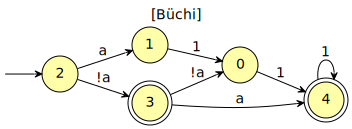

In [25]:
spec = Specification("(XX(0) -> (!a&Xa))")
spec.automaton